In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale
import skimage.color as color
import cv2
from PIL import Image
from skimage.external import tifffile
import os
from skimage.transform import resize


In [137]:

def stretch_8bit(bands, lower_percent=0, higher_percent=100):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)    
    
    


def stretch_n(bands, lower_percent=5, higher_percent=95):
    # out = np.zeros_like(bands)
    out = np.zeros_like(bands).astype(np.float32)

    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band) # original:  255
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)    


In [138]:
inDir = 'data'
resize_fraction = 0.
min_image_width = 500

def _align_two_rasters(img1,img2):
    try:
        p1 = img1[10:300,50:450,1].astype(np.float32)
        p2 = img2[10:300,50:450,4].astype(np.float32)
    except:
        print("_align_two_rasters: can't extract patch, falling back to whole image")
        p1 = img1[:,:,1]
        p2 = img2[:,:,4]

    # lp1 = cv2.Laplacian(p1,cv2.CV_32F,ksize=5)
    # lp2 = cv2.Laplacian(p2,cv2.CV_32F,ksize=5)

    warp_mode = cv2.MOTION_EUCLIDEAN
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000,  1e-7)
    (cc, warp_matrix) = cv2.findTransformECC (p1, p2,warp_matrix,  warp_mode, criteria)
    print("_align_two_rasters: cc:{}".format(cc))

    img3 = cv2.warpAffine(img2, warp_matrix, (img1.shape[1], img1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    img3[img3 == 0] = np.average(img3)

    return img3


#Fetch and resize RGB images (simple 3 band) 
def RGB(image_id):
    filename = os.path.join(inDir, 'three_band', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    img = cv2.resize(img,(min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC)
#     return stretch_n(img)
    return img



def A(image_id):

    filename = os.path.join(inDir, 'sixteen_band', '{}_A.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    img = cv2.resize(img, (min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC) 

#     return stretch_n(img)
    return img

def M(image_id):
 
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    img = cv2.resize(img, (min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC) 

#     return stretch_n(img)
    return img


def get_image(image_id):
    rgb = RGB(image_id)

    m = M(image_id)
    m = _align_two_rasters(rgb,m)
    
    a = A(image_id)
    a = _align_two_rasters(rgb,a)
    
    
    img = np.zeros((rgb.shape[0],rgb.shape[1],19), 'uint16')
    img[..., 0:3] = rgb
    img[..., 3:11] = m
    img[..., 11:19] = a
    return img
# # def P(image_id):

#     filename = os.path.join(inDir, 'sixteen_band', '{}_P.tif'.format(image_id))
#     img = tiff.imread(filename)
# #     img = np.rollaxis(img, 0, 3)
#     img = cv2.resize(img, (min_image_width, min_image_width), interpolation = cv2.INTER_CUBIC) 
#     return img




    

_align_two_rasters: cc:0.940697986439
(500L, 500L, 8L)


(<matplotlib.figure.Figure at 0x8d6d1860>,
 <matplotlib.image.AxesImage at 0x8d4241d0>)

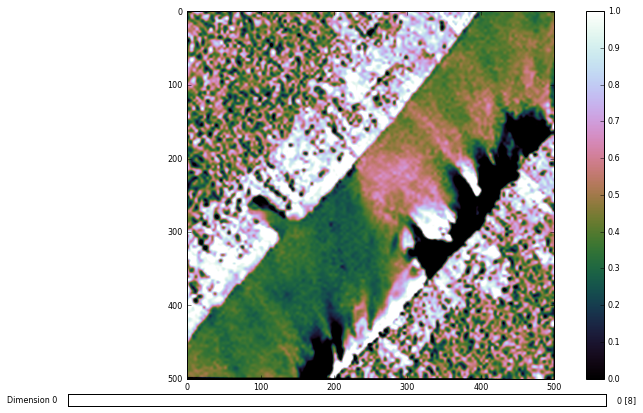

In [140]:
IM_ID = '6050_0_0'
a =  A('6050_0_0')
m = M('6050_0_0')
rgb = RGB('6050_0_0')

aligned = _align_two_rasters(rgb,a)
# aligned = 255 * (aligned.astype(np.float32)-300) / (np.max(aligned) * 1.1) + 40
print aligned.shape
# print np.rollaxis(P('6120_2_2'),2,0).shape
# # tiff.imshow(stretch_n(np.rollaxis(M('6120_2_2'),2,0)))
# tiff.imshow(np.rollaxis(stretch_n(stretch_n(A('6050_0_0'))),2,0))
tiff.imshow(np.rollaxis(stretch_n(aligned),2,0))
# tiff.imshow(np.rollaxis(aligned,2,0))

# tiff.imshow(aligned[:,:,2])

(<matplotlib.figure.Figure at 0x887350b8>,
 <matplotlib.image.AxesImage at 0x88a8d5f8>)

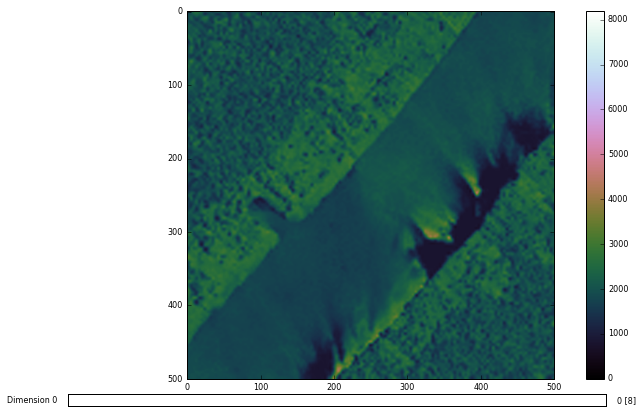

In [132]:
# tiff.imshow(np.rollaxis(stretch_n(A('6050_0_0')),2,0))
tiff.imshow(np.rollaxis(a,2,0))
# tiff.imshow(rgb[:,:,1])



_align_two_rasters: cc:0.996857725644
_align_two_rasters: cc:0.940697986439


(<matplotlib.figure.Figure at 0x88735b70>,
 <matplotlib.image.AxesImage at 0x8d36d7f0>)

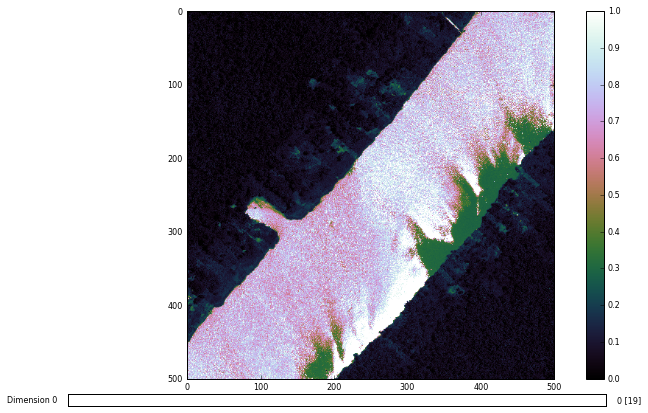

In [139]:
tiff.imshow(np.rollaxis(stretch_n( get_image(IM_ID)),2,0))
# tiff.imshow(get_image(IM_ID)[:,:,1])

(<matplotlib.figure.Figure at 0x89de18d0>,
 <matplotlib.image.AxesImage at 0x8bcff4e0>)

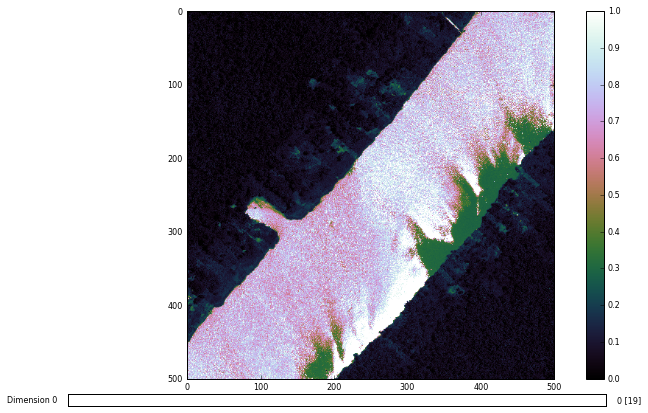

In [136]:
tiff.imshow(np.rollaxis(stretch_n( get_image(IM_ID)),2,0))


(<matplotlib.figure.Figure at 0x8d27a710>,
 <matplotlib.image.AxesImage at 0x8e23fcc0>)

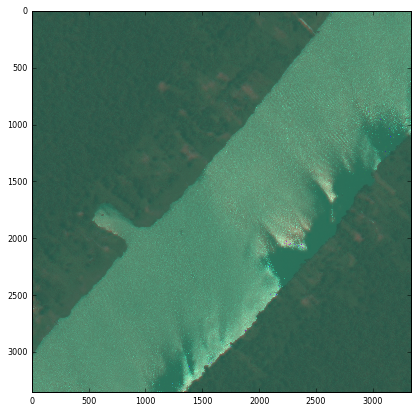

In [143]:
# read m and p data
IM_ID = '6050_0_0'

image_id = "6050_0_0"
img_3 = np.transpose(tiff.imread("data/three_band/{}.tif".format(image_id)),(1,2,0))
img_a = np.transpose(tiff.imread("data/sixteen_band/{}_A.tif".format(image_id)),(1,2,0))

raster_size = img_3.shape
img_a = cv2.resize(img_a,(raster_size[1],raster_size[0]),interpolation=cv2.INTER_CUBIC)

img_a = 255 * (img_a.astype(np.float32)-300) / (np.max(img_a) * 1.1) + 40
img_3 = 255 * img_3.astype(np.float32) / (np.max(img_3) * 0.9) + 60
# img_a_new = 255 * (img_a_new.astype(np.float32)-300) / (np.max(img_a_new) * 1.1) + 40

img_orig = np.stack([img_a[:, :, 4], img_3[:, :, 1], img_3[:, :, 0]], axis=-1).astype(np.uint8)

tiff.imshow(img_orig)
# rgb =  tiff.imread('data/three_band/{}.tif'.format(IM_ID))
# # tiff.imread(
# # m = tiff.imread('data/sixteen_band/{}_M.tif'.format(IM_ID))
# # pan = tiff.imread('data/sixteen_band/6120_2_2_P.tif')
# a =  tiff.imread('data/sixteen_band/{}_A.tif'.format(IM_ID))
# # print ('m_shape: ', m.shape)
# print ('pan_shape: ', pan.shape)
# print ('a_shape: ', a.shape)
# img = np.rollaxis(rgb, 0, 3)
# print ('rgb_shape: ',  rgb.shape)
# tiff.imshow(stretch_n(img))


(670L, 679L, 3L)


(<matplotlib.figure.Figure at 0x1614e9470>,
 <matplotlib.image.AxesImage at 0x161d644e0>)

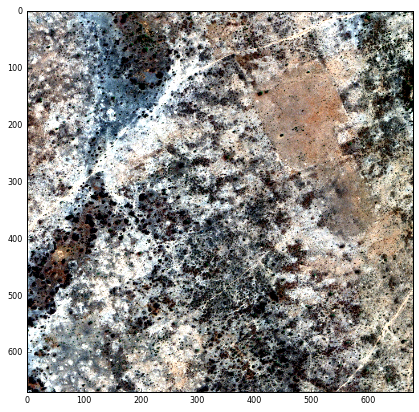

In [135]:
resized = cv2.resize(img,None, fx =0.2, fy=0.2,interpolation = cv2.INTER_CUBIC)
print resized.shape
tiff.imshow(stretch_n(resized))

(512, 512)


(<matplotlib.figure.Figure at 0x2230bb050>,
 <matplotlib.image.AxesImage at 0x21be01290>)

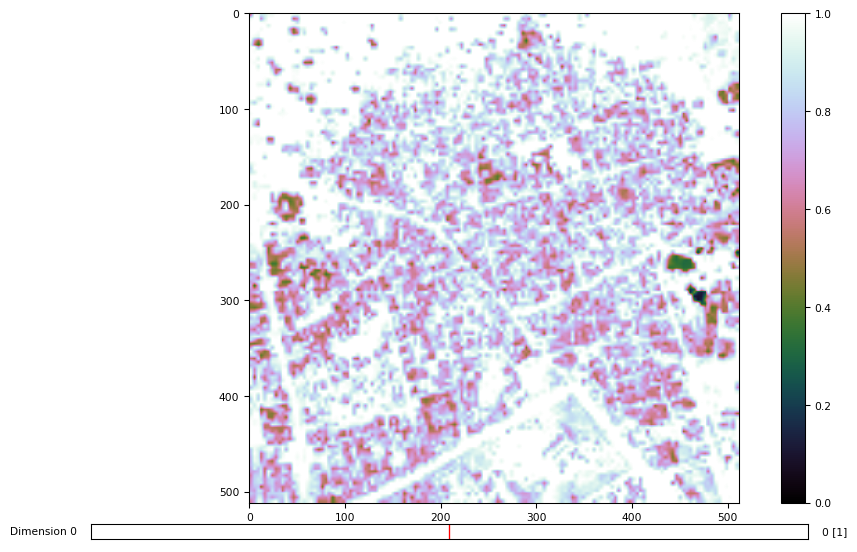

In [181]:
rs = cv2.resize(stretch_n(a)[1,:,:],(512,512))
print rs.shape
tiff.imshow(rs)

In [32]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0 
        b = 1 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.float32)





def CCCI_index(m, rgb):
    RE  = resize(m[5,:,:], (rgb.shape[0], rgb.shape[1])) 
    MIR = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1])) 
    R = rgb[:,:,0]
    # canopy chloropyll content index
    CCCI = (MIR-RE)/(MIR+RE)*(MIR-R)/(MIR+R)
    return CCCI    
 
IM_ID = "6150_3_4"
 # read rgb and m bands
rgb = tiff.imread('data/three_band/{}.tif'.format(IM_ID))
rgb = np.rollaxis(rgb, 0, 3)
m = tiff.imread('data/sixteen_band/{}_M.tif'.format(IM_ID))

# get our index
CCCI = CCCI_index(m, rgb) 

# you can look on histogram and pick your favorite threshold value(0.11 is my best)
binary = (CCCI > 0.11).astype(np.float32)


CCCI = CCCI_index(img, rgb) 
# you can look on histogram and pick your favorite threshold value(0.11 is my best)
binary = (CCCI > 0.11).astype(np.float32)



NameError: name 'tif' is not defined

(<matplotlib.figure.Figure at 0x104bc4a8>,
 <matplotlib.image.AxesImage at 0x13493630>)

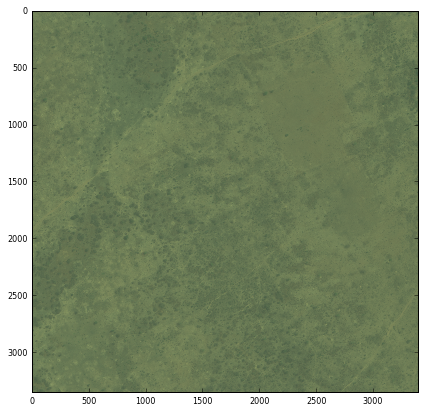

In [33]:
tiff.imshow(rgb)

In [30]:
print CCCI.shape


(3349L, 3396L)


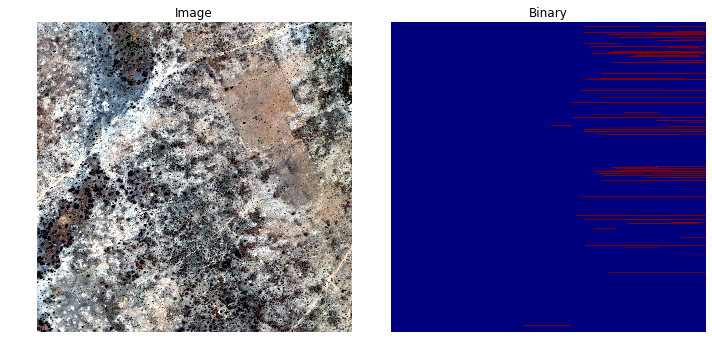

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(stretch_8bit(rgb))
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(binary)
ax[1].set_title('Binary')
ax[1].axis('off')
plt.tight_layout()
plt.show()
